### Import packages and data

In [9]:
import numpy as np
import anndata as ad
import scanpy as sc
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from scipy.stats import spearmanr


In [21]:
adata=sc.datasets.pbmc3k_processed()

  0%|          | 0.00/23.5M [00:00<?, ?B/s]

In [ ]:
dir=

In [ ]:
adata=ad.read(dir)

### Define a set of markers for a cell type

In [61]:
# T cells
t_cell_markers = ["CD3D", "CD3E", "CD3G", "CD4", "CD8A", "CD8B", "IL7R", "CCR7"]

# B cells
b_cell_markers = ["MS4A1", "CD19", "CD79A"]

# NK cells
nk_cell_markers = ["NKG7", "GNLY", "KLRD1", "NCAM1", "FCGR3A"]

# Monocytes
monocyte_markers = ["CD14", "LYZ", "FCN1", "FCGR3A"]

# Dendritic cells
dendritic_cell_markers = ["FCER1A", "CLEC9A", "BATF3", "IRF8", "CD1C"]

# Megakaryocytes / Platelets
megakaryocyte_markers = ["PPBP", "PF4", "ITGA2B", "GP1BA"]


#### Score of markers list

In [62]:
sc.tl.score_genes(adata,b_cell_markers, ctrl_as_ref=True, ctrl_size=50, gene_pool=None, 
                      n_bins=25, score_name='score_b_cell', random_state=0, copy=False, use_raw=None, layer=None)


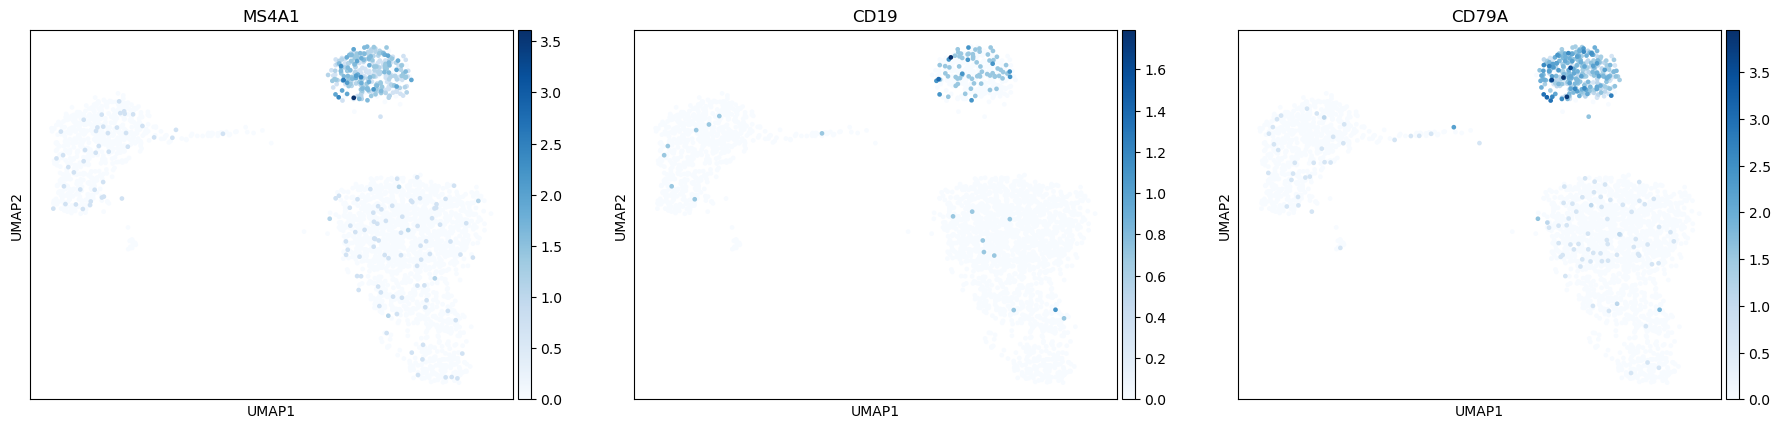

In [63]:
sc.pl.umap(adata,color=b_cell_markers,cmap='Blues')

### Metrics provided by scanpy

#### Geary’s C
It is a measure of spatial autocorrelation for a numerical variable (e.g., gene expression) on a graph (such as a k-nearest neighbor graph from UMAP or spatial coordinates).
It evaluates whether cells with similar values are close together.

It specifically quantifies local dissimilarity:
Are cells near each other similar or different in value?
The lower the better

In [64]:
sc.metrics.gearys_c(adata, vals=adata.obs["score_b_cell"],obsm="X_umap")

0.17460187735503205

#### Moran’s I 

It is a global autocorrelation statistic that quantifies how similar values of a variable (e.g., gene expression) are across a graph structure or spatial map. It is commonly used in spatial data analysis, including 2D spatial grids and single-cell embeddings (e.g., UMAP or spatial transcriptomics).

It evaluates whether high or low values cluster together in the graph.

Closely related to Geary’s C, but emphasizes global rather than local similarity.

The closer to 2 the better

In [65]:
sc.metrics.morans_i(adata, vals=adata.obs["score_b_cell"],obsm="X_umap")

0.8173552069342824

#### Custom metric

This function evaluates how spatially localized the expression of a gene or gene set is within a low-dimensional embedding (e.g., UMAP), using three neighborhood-based scores:

It will give as output:
local_corr	Correlation between a cell’s expression and its nearest neighbors → local coherence
distant_corr	Correlation with farthest cells in the embedding → checks for global smearing (overintegration)
random_corr	Correlation with random cells → acts as a baseline control

In [66]:
def marker_spatial_expression_scores(
    adata,
    genes,
    embedding='X_umap',
    n_neighbors=15,
    n_distant=15,
    n_random=15,
    agg='mean',
    seed=42
):
    """
    Evaluate whether a gene or gene set is:
    - Locally clustered (local_corr)
    - Globally exclusive (distant_corr)
    - Different from random placement (random_corr)

    Parameters:
    - genes: str or list of genes
    - embedding: key in adata.obsm (e.g., 'X_umap')
    - n_neighbors: # of nearest neighbors for local
    - n_distant: # of farthest cells for distant
    - n_random: # of random cells for random
    - agg: 'mean' or 'sum' for combining gene expressions
    - seed: for reproducibility of random sampling

    Returns:
    - Dictionary of local_corr, distant_corr, random_corr
    """

    if embedding not in adata.obsm:
        raise ValueError(f"{embedding} not found in adata.obsm")

    if isinstance(genes, str):
        genes = [genes]
    for g in genes:
        if g not in adata.var_names:
            raise ValueError(f"Gene '{g}' not found in adata.var_names")

    coords = adata.obsm[embedding]
    expr_matrix = adata[:, genes].X
    if hasattr(expr_matrix, 'toarray'):
        expr_matrix = expr_matrix.toarray()

    # Combine gene expression
    if agg == 'mean':
        expr = expr_matrix.mean(axis=1)
    elif agg == 'sum':
        expr = expr_matrix.sum(axis=1)
    else:
        raise ValueError("agg must be 'mean' or 'sum'")

    # Nearest neighbors (local structure)
    nn = NearestNeighbors(n_neighbors=n_neighbors).fit(coords)
    local_neighbors = nn.kneighbors(coords, return_distance=False)
    local_means = np.array([expr[neigh].mean() for neigh in local_neighbors])
    local_corr, _ = spearmanr(expr, local_means)

    # Farthest neighbors (distant structure)
    dist_matrix = pairwise_distances(coords)
    np.fill_diagonal(dist_matrix, -np.inf)
    distant_neighbors = np.argsort(dist_matrix, axis=1)[:, -n_distant:]
    distant_means = np.array([expr[neigh].mean() for neigh in distant_neighbors])
    distant_corr, _ = spearmanr(expr, distant_means)

    # Random neighbors (control)
    np.random.seed(seed)
    random_neighbors = np.array([np.random.choice(len(expr), size=n_random, replace=False)
                                 for _ in range(len(expr))])
    random_means = np.array([expr[neigh].mean() for neigh in random_neighbors])
    random_corr, _ = spearmanr(expr, random_means)

    return {
        "local_corr": local_corr,
        "distant_corr": distant_corr,
        "random_corr": random_corr
    }


In [67]:
scores = marker_spatial_expression_scores(adata, b_cell_markers)
print("Local correlation:", scores["local_corr"])
print("Distant correlation:", scores["distant_corr"])
print("Random correlation:", scores["random_corr"])


Local correlation: 0.6170780157593005
Distant correlation: 0.28115831152425474
Random correlation: 0.0015043835446156614


### Overintegration check